********Generate Dataset********

In [1]:
import pandas as pd
import numpy as np
from faker import Faker

# -----------------------
# Setup
# -----------------------
fake = Faker()
np.random.seed(42)
Faker.seed(42)

ROWS = 50000
FRAUD_RATE = 0.035

#Ye merchant, transaction and country teeno hee repeat hoti hai aur unka distribution bhi fix hai. Isliye unko loop ke bahar define kar diya hai.
merchant_categories = [
    "Grocery", "Fuel", "Electronics",
    "Travel", "Dining", "E-commerce"
]
transaction_types = ["Online", "POS", "ATM"]
countries = ["India", "USA", "UK", "UAE", "Singapore"]

records = [] #ye empty list hai jisme data store hoga.

# -----------------------
# Data Generation Loop
# -----------------------
for _ in range(ROWS):

    # Fraud flag
    is_fraud = np.random.choice([0, 1], p=[1 - FRAUD_RATE, FRAUD_RATE])

    # Transaction amount
    amount = (
        np.random.normal(2500, 1200)
        if is_fraud == 0
        else np.random.uniform(8000, 50000)
    )

    # Time gap (velocity)
    hours_gap = (
        np.random.exponential(10)
        if is_fraud == 0
        else np.random.uniform(0.1, 1.5)
    )

    # Foreign transaction flag
    foreign_txn = (
        np.random.choice([0, 1], p=[0.85, 0.15])
        if is_fraud == 0
        else np.random.choice([0, 1], p=[0.3, 0.7])
    )

    # Risk score
    risk_score = round(
        (amount / 50000) * 0.4 +
        (1 / max(hours_gap, 0.1)) * 0.4 +
        foreign_txn * 0.2,
        2
    )

    # Append record
    records.append({
        "transaction_id": fake.uuid4(),
        "transaction_date": fake.date_time_between("-6M", "now"),
        "customer_id": f"CUST-{np.random.randint(10000, 99999)}",
        "merchant_category": np.random.choice(merchant_categories),
        "transaction_amount": round(max(amount, 50), 2),
        "transaction_type": np.random.choice(transaction_types),
        "merchant_country": np.random.choice(countries),
        "hours_since_last_txn": round(hours_gap, 2),
        "is_foreign_transaction": foreign_txn,
        "fraud_risk_score": risk_score,
        "is_fraud": is_fraud
    })

# -----------------------
# Create DataFrame & Save
# -----------------------
df = pd.DataFrame(records)
df.to_csv("transactions.csv", index=False)

print(df.shape)
print(df["is_fraud"].value_counts(normalize=True))


(50000, 11)
is_fraud
0    0.96468
1    0.03532
Name: proportion, dtype: float64


*Customer Dataset*

In [2]:
import pandas as pd
import numpy as np
from faker import Faker

fake = Faker()
np.random.seed(42)

# --------------------------------
# Step 1: Transactions se unique customer_id nikaalna
# --------------------------------
# Kyun: Customers dataset ko transactions se link karna hai
customer_ids = df["customer_id"].unique()

# --------------------------------
# Step 2: Empty list banani (records store karne ke liye)
# --------------------------------
customer_records = []

# --------------------------------
# Step 3: Har customer ke liye profile banana
# --------------------------------
for cust_id in customer_ids:

    # Age generate karna (realistic banking range)
    age = np.random.randint(18, 70)

    # Income band decide karna (simple segmentation)
    income_band = np.random.choice(
        ["Low", "Medium", "High"],
        p=[0.4, 0.4, 0.2]   # zyada log low/medium income hote hain
    )

    # Credit score generate karna
    credit_score = (
        np.random.randint(300, 600) if income_band == "Low"
        else np.random.randint(550, 750) if income_band == "Medium"
        else np.random.randint(700, 900)
    )
    # Low income → low credit score, High income → better score

    # Customer since date (kab se bank ka customer hai)
    customer_since = fake.date_between(start_date="-10y", end_date="-1y")

    # Home country
    home_country = np.random.choice(
        ["India", "USA", "UK", "UAE", "Singapore"],
        p=[0.6, 0.15, 0.1, 0.1, 0.05]
    )

    # Risk segment derive karna (business-friendly label)
    if credit_score < 550:
        risk_segment = "High"
    elif credit_score < 700:
        risk_segment = "Medium"
    else:
        risk_segment = "Low"

    # --------------------------------
    # Step 4: Customer record append karna
    # --------------------------------
    customer_records.append({
        "customer_id": cust_id,
        "age": age,
        "income_band": income_band,
        "credit_score": credit_score,
        "customer_since": customer_since,
        "home_country": home_country,
        "risk_segment": risk_segment
    })

# --------------------------------
# Step 5: DataFrame banana
# --------------------------------
customers_df = pd.DataFrame(customer_records)

# --------------------------------
# Step 6: CSV me save karna
# --------------------------------
customers_df.to_csv("customers.csv", index=False)

# Quick sanity check
print(customers_df.shape)
customers_df.head()


(38413, 7)


,customer_id,age,income_band,credit_score,customer_since,home_country,risk_segment
0,CUST-54131,56,Medium,564,2020-02-18,USA,Medium
1,CUST-93104,38,Low,514,2020-03-07,India,High
2,CUST-28431,41,Low,451,2020-01-27,USA,High
3,CUST-90038,19,Medium,707,2022-07-08,India,Low
4,CUST-33483,38,Medium,607,2018-09-05,India,Medium


*Merchants Dataset*

In [3]:
import pandas as pd
import numpy as np

np.random.seed(42)

# --------------------------------
# Step 1: Transactions se unique merchant_category nikaalna
# --------------------------------
# Kyun: Merchants ko transactions se link karna hai
merchant_categories = df["merchant_category"].unique()

# --------------------------------
# Step 2: Empty list banani (merchant records store karne ke liye)
# --------------------------------
merchant_records = []

# --------------------------------
# Step 3: Har merchant category ke liye profile banana
# --------------------------------
for category in merchant_categories:

    # Average transaction value (category-specific behavior)
    avg_txn_value = np.random.uniform(500, 5000)
    # Grocery/Fuel jaise categories lower, Travel/Electronics higher ho sakte hain

    # Merchant country (mostly domestic, thoda foreign mix)
    merchant_country = np.random.choice(
        ["India", "USA", "UK", "UAE", "Singapore"],
        p=[0.55, 0.15, 0.1, 0.1, 0.1]
    )

    # Merchant risk score (0–1 scale)
    merchant_risk_score = round(
        (avg_txn_value / 5000) * 0.6 +
        np.random.uniform(0, 0.4),
        2
    )
    # High avg value + randomness = higher risk

    # --------------------------------
    # Step 4: Merchant record append karna
    # --------------------------------
    merchant_records.append({
        "merchant_category": category,
        "merchant_country": merchant_country,
        "avg_transaction_value": round(avg_txn_value, 2),
        "merchant_risk_score": merchant_risk_score
    })

# --------------------------------
# Step 5: DataFrame banana
# --------------------------------
merchants_df = pd.DataFrame(merchant_records)

# --------------------------------
# Step 6: CSV me save karna
# --------------------------------
merchants_df.to_csv("merchants.csv", index=False)

# Quick sanity check
print(merchants_df.shape)
merchants_df.head()


(6, 4)


,merchant_category,merchant_country,avg_transaction_value,merchant_risk_score
0,Electronics,Singapore,2185.43,0.56
1,Travel,India,3193.96,0.45
2,Fuel,UAE,761.38,0.33
3,E-commerce,India,3686.33,0.83
4,Dining,India,4245.99,0.58


*Left-Join*

In [4]:
# Ensure transactions dataframe is available (cell execution order may vary)
try:
    df  # if df exists, use it
except NameError:
    # load from CSV created earlier
    df = pd.read_csv("transactions.csv", parse_dates=["transaction_date"])

# Ensure customers_df is available
try:
    customers_df
except NameError:
    customers_df = pd.read_csv("customers.csv", parse_dates=["customer_since"])

# Ensure merchants_df is available
try:
    merchants_df
except NameError:
    merchants_df = pd.read_csv("merchants.csv")

# LEFT JOIN because every transaction is important
df_txn_customer = pd.merge(
    df,
    customers_df,
    on="customer_id",
    how="left"
)

# Check output
print(df_txn_customer.head())
print(df_txn_customer.shape)

# join with merchants on the correct key
final_df = pd.merge(
    df_txn_customer,
    merchants_df,
    on="merchant_category",
    how="left"
)

# Final dataset preview
print(final_df.head())
print(final_df.shape)


                         transaction_id    transaction_date customer_id  \
0  bdd640fb-0667-4ad1-9c80-317fa3b1799d 2025-08-25 16:45:46  CUST-54131   
1  bc8960a9-23b8-41e9-b924-56de3eb13b90 2025-07-23 04:41:43  CUST-93104   
2  8b9d2434-e465-4150-bd9c-66b3ad3c2d6d 2025-07-20 04:11:51  CUST-28431   
3  07a0ca6e-0822-48f3-ac03-1199972a8469 2025-07-21 11:41:05  CUST-90038   
4  9a1de644-815e-46d1-bb8f-aa1837f8a88b 2025-07-08 10:41:59  CUST-33483   

  merchant_category  transaction_amount transaction_type merchant_country  \
0       Electronics             1165.74              POS        Singapore   
1            Travel            42962.59              POS        Singapore   
2            Travel             2882.68              ATM               UK   
3              Fuel             2470.65           Online              UAE   
4            Travel             2926.66           Online               UK   

   hours_since_last_txn  is_foreign_transaction  fraud_risk_score  is_fraud  \
0      

In [5]:
final_df = pd.merge(
    df_txn_customer,
    merchants_df,
    on="merchant_category",
    how="left"
)


In [6]:
final_df.to_csv("final_dataset.csv", index=False)

In [7]:
final_df.shape

(50000, 20)

In [8]:
customers_df.shape

(38413, 7)

In [9]:
merchants_df.shape

(6, 4)

In [10]:
df.shape

(50000, 11)

***Confirm Data Integrity***

In [11]:
final_df.shape
final_df.isnull().sum()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_id          50000 non-null  object        
 1   transaction_date        50000 non-null  datetime64[ns]
 2   customer_id             50000 non-null  object        
 3   merchant_category       50000 non-null  object        
 4   transaction_amount      50000 non-null  float64       
 5   transaction_type        50000 non-null  object        
 6   merchant_country_x      50000 non-null  object        
 7   hours_since_last_txn    50000 non-null  float64       
 8   is_foreign_transaction  50000 non-null  int64         
 9   fraud_risk_score        50000 non-null  float64       
 10  is_fraud                50000 non-null  int64         
 11  age                     50000 non-null  int64         
 12  income_band             50000 non-null  object

In [12]:
int_col = final_df.select_dtypes(include='int64').columns
print(int_col)

Index(['is_foreign_transaction', 'is_fraud', 'age', 'credit_score'], dtype='object')


In [13]:
obj_col = final_df.select_dtypes(include='object').columns
print(obj_col)

Index(['transaction_id', 'customer_id', 'merchant_category',
       'transaction_type', 'merchant_country_x', 'income_band',
       'customer_since', 'home_country', 'risk_segment', 'merchant_country_y'],
      dtype='object')


In [14]:
# Step 1: Identify object columns to encode (exclude identifiers)
# Identifiers like transaction_id and customer_id shouldn't be one-hot encoded
object_cols = final_df.select_dtypes(include='object').columns
cols_to_encode = [col for col in object_cols if col not in ['transaction_id', 'customer_id']]

# Step 2: Apply One-Hot Encoding only to categorical features
final_df_ohe = pd.get_dummies(
    final_df,
    columns=cols_to_encode,
    drop_first=True
)

# Step 3: Sanity check
print(final_df_ohe.shape)
final_df_ohe.info()


(50000, 3319)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 3319 entries, transaction_id to merchant_country_y_UAE
dtypes: bool(3307), datetime64[ns](1), float64(5), int64(4), object(2)
memory usage: 162.3+ MB


*Another Way*

In [15]:
# 1) IDs drop karo (modeling dataset se)
final_df_model = final_df.drop(columns=['transaction_id', 'customer_id'])

# 2) Sirf real categorical (object) columns identify karo
cat_cols = final_df_model.select_dtypes(include='object').columns

# 3) One-Hot Encoding apply karo
final_df_model = pd.get_dummies(
    final_df_model,
    columns=cat_cols,
    drop_first=True
)

# 4) Sanity checks
final_df_model.shape
final_df_model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 3317 entries, transaction_date to merchant_country_y_UAE
dtypes: bool(3307), datetime64[ns](1), float64(5), int64(4)
memory usage: 161.5 MB


In [16]:
final_df_model.isnull().sum().max()


np.int64(0)

In [17]:
#Check karo ki is_fraud abhi bhi same hai.
final_df_model['is_fraud'].value_counts(normalize=True) * 100


is_fraud
0    96.468
1     3.532
Name: proportion, dtype: float64

In [18]:
final_df_model.select_dtypes(include='object').columns


Index([], dtype='object')

***🔹 STEP 4: Target Variable (is_fraud) EDA
🎯 Objective

Samajhna:

Fraud kitna rare hai?

Class imbalance ka level kya hai?

Modeling me kya implications hongi?***

In [19]:
final_df_model['is_fraud'].value_counts()
#to know the count of fraud and non-fraud transactions

is_fraud
0    48234
1     1766
Name: count, dtype: int64

In [20]:
final_df_model['is_fraud'].value_counts(normalize=True) * 100
#to know the percentage of fraud and non-fraud transactions
#Interpretation guide:

'''< 2% fraud → highly imbalanced

2–5% fraud → typical real-world fraud

> 10% fraud → synthetic / suspiciously balanced'''

'< 2% fraud → highly imbalanced\n\n2–5% fraud → typical real-world fraud\n\n> 10% fraud → synthetic / suspiciously balanced'

In [21]:
final_df_model['transaction_amount'].describe()


count    50000.000000
mean      3455.246469
std       5573.186461
min         50.000000
25%       1726.745000
50%       2553.690000
75%       3414.832500
max      49981.090000
Name: transaction_amount, dtype: float64

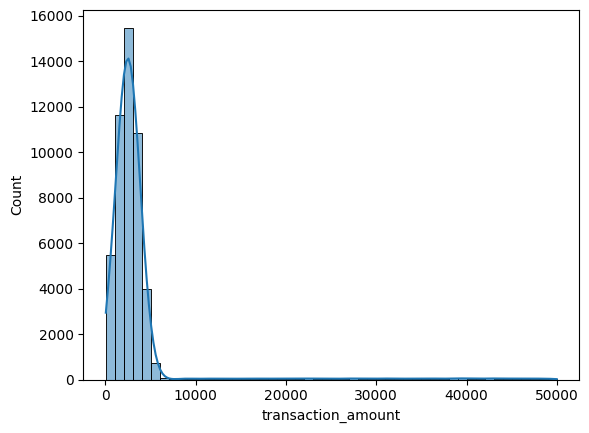

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(final_df_model['transaction_amount'], bins=50, kde=True)
plt.show()


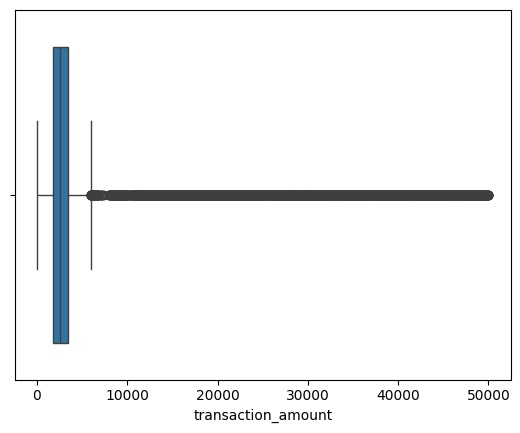

In [23]:
sns.boxplot(x=final_df_model['transaction_amount'])
plt.show() 
#to check for outliers in transaction amount

In [24]:
final_df_model.groupby('is_fraud')['transaction_amount'].describe()
#to see transaction amount stats by fraud vs non-fraud

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,48234.0,2506.237391,1176.205527,50.00,1691.5375,2499.065,3309.66,7466.81
1,1766.0,29375.124077,12051.611141,8009.94,19009.2300,29741.510,39745.46,49981.09


In [25]:
final_df_model[['transaction_amount']].head()

,transaction_amount
0,1165.74
1,42962.59
2,2882.68
3,2470.65
4,2926.66


**Time_gap EDA**

In [26]:
# 'time_gap' column does not exist; use 'hours_since_last_txn' instead
final_df_model['hours_since_last_txn'].describe()


count    50000.000000
mean         9.679872
std          9.978631
min          0.000000
25%          2.500000
50%          6.540000
75%         13.530000
max         97.260000
Name: hours_since_last_txn, dtype: float64

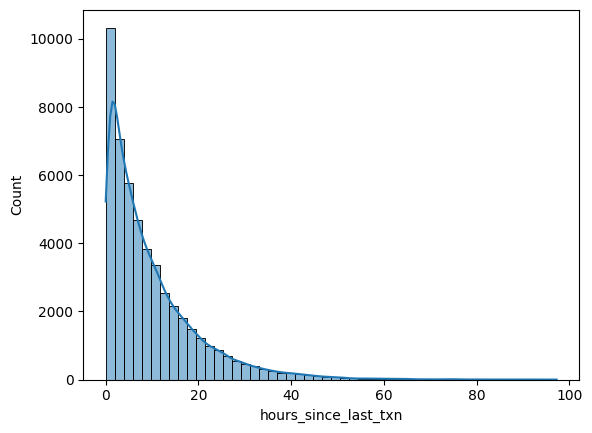

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(final_df_model['hours_since_last_txn'], bins=50, kde=True)
plt.show()


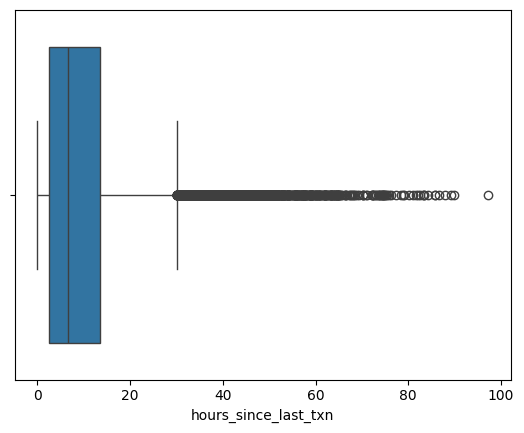

In [28]:
sns.boxplot(x=final_df_model['hours_since_last_txn'])
plt.show()


In [29]:
#Comparision
final_df_model.groupby('is_fraud')['hours_since_last_txn'].describe()


,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,48234.0,10.005167,10.010838,0.0,2.85,6.900,13.87,97.26
1,1766.0,0.795232,0.403803,0.1,0.45,0.785,1.14,1.50


**Amount vs Time_gap EDA**

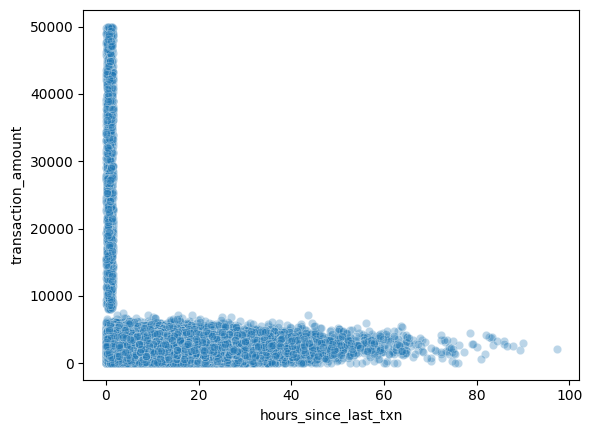

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=final_df_model,
    x='hours_since_last_txn',
    y='transaction_amount',
    alpha=0.3
)
plt.show()


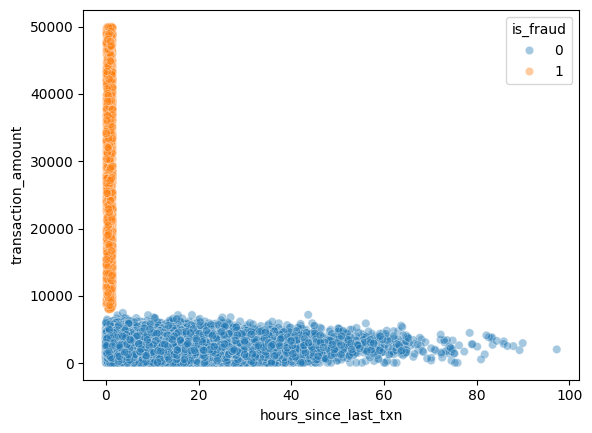

In [31]:
sns.scatterplot(
    data=final_df_model,
    x='hours_since_last_txn',
    y='transaction_amount',
    hue='is_fraud',
    alpha=0.4
)
plt.show()


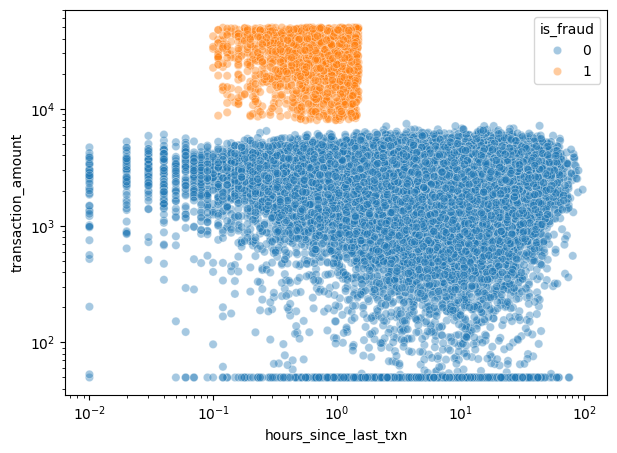

In [32]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=final_df_model,
    x='hours_since_last_txn',
    y='transaction_amount',
    hue='is_fraud',
    alpha=0.4
)
plt.yscale('log')
plt.xscale('log')
plt.show()


**Merchant_category EDA**

In [33]:
final_df['merchant_category'].value_counts()


merchant_category
Electronics    8403
E-commerce     8395
Grocery        8321
Dining         8312
Fuel           8304
Travel         8265
Name: count, dtype: int64

In [34]:
pd.crosstab(
    final_df['merchant_category'],
    final_df['is_fraud'],
    normalize='index'
) * 100


is_fraud,0,1
merchant_category,,
Dining,96.847931,3.152069
E-commerce,96.319238,3.680762
Electronics,96.429846,3.570154
Fuel,96.616089,3.383911
Grocery,96.262468,3.737532
Travel,96.333938,3.666062


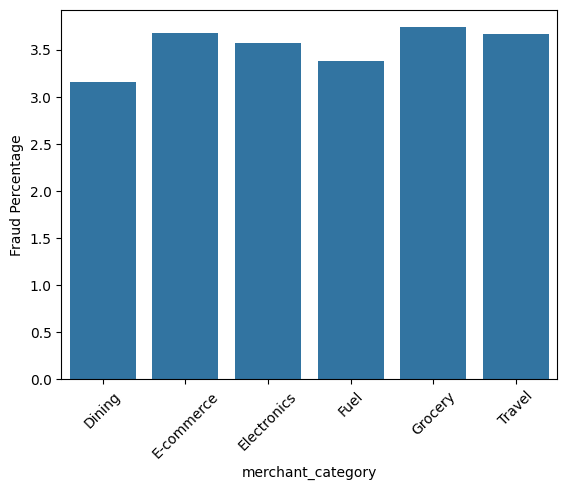

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

fraud_rate = (
    pd.crosstab(
        final_df['merchant_category'],
        final_df['is_fraud'],
        normalize='index'
    ) * 100
).reset_index()

sns.barplot(
    data=fraud_rate,
    x='merchant_category',
    y=1
)
plt.xticks(rotation=45)
plt.ylabel('Fraud Percentage')
plt.show()


**Transaction_type EDA**

In [36]:
final_df['transaction_type'].value_counts()


transaction_type
Online    16739
POS       16672
ATM       16589
Name: count, dtype: int64

In [37]:
pd.crosstab(
    final_df['transaction_type'],
    final_df['is_fraud'],
    normalize='index'
) * 100


is_fraud,0,1
transaction_type,,
ATM,96.286696,3.713304
Online,96.660493,3.339507
POS,96.455134,3.544866


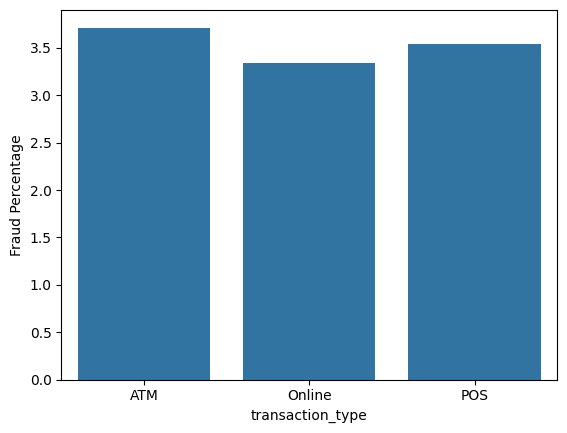

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

fraud_rate_tt = (
    pd.crosstab(
        final_df['transaction_type'],
        final_df['is_fraud'],
        normalize='index'
    ) * 100
).reset_index()

sns.barplot(
    data=fraud_rate_tt,
    x='transaction_type',
    y=1
)
plt.ylabel('Fraud Percentage')
plt.show()


**Country_EDA**

In [39]:
# use existing merchant country column from the merged dataframe
final_df['merchant_country_x'].value_counts()


merchant_country_x
Singapore    10139
UAE          10071
UK            9941
India         9935
USA           9914
Name: count, dtype: int64

In [40]:
pd.crosstab(
    final_df['merchant_country_x'],
    final_df['is_fraud'],
    normalize='index'
) * 100


is_fraud,0,1
merchant_country_x,,
India,96.708606,3.291394
Singapore,96.419765,3.580235
UAE,96.604111,3.395889
UK,96.157328,3.842672
USA,96.449465,3.550535


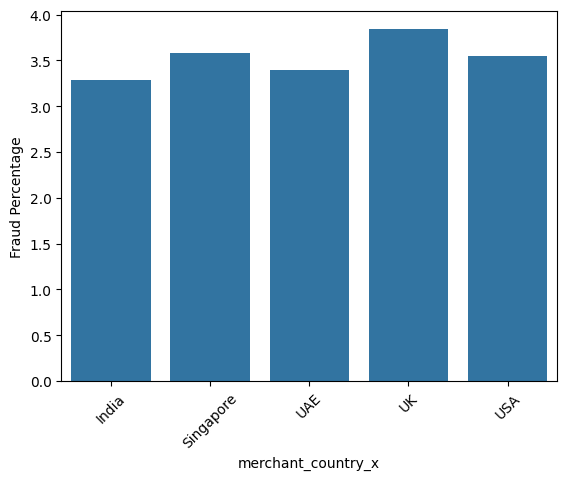

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

fraud_rate_country = (
    pd.crosstab(
        final_df['merchant_country_x'],
        final_df['is_fraud'],
        normalize='index'
    ) * 100
).reset_index()

sns.barplot(
    data=fraud_rate_country,
    x='merchant_country_x',
    y=1
)
plt.ylabel('Fraud Percentage')
plt.xticks(rotation=45)
plt.show()


**Feature engineering start**

In [42]:
# 1) Threshold nikaalo (95th percentile)
high_amount_threshold = final_df_model['transaction_amount'].quantile(0.95)

# 2) Binary flag banao
final_df_model['high_amount_flag'] = (
    final_df_model['transaction_amount'] > high_amount_threshold
).astype(int)

# 3) Quick sanity check
final_df_model['high_amount_flag'].value_counts(normalize=True) * 100


high_amount_flag
0    95.0
1     5.0
Name: proportion, dtype: float64

**Time_gap flag**

In [43]:
# 1) Velocity-based flag
final_df_model['rapid_txn_flag'] = (
    final_df_model['hours_since_last_txn'] < 60
).astype(int)

# 2) Sanity check
final_df_model['rapid_txn_flag'].value_counts(normalize=True) * 100


rapid_txn_flag
1    99.756
0     0.244
Name: proportion, dtype: float64

**Dormant account flag**

In [45]:
# 1) 30 days threshold (in seconds)
DORMANT_THRESHOLD = 30 * 24 * 60 * 60

# 2) Dormant account flag
final_df_model['dormant_account_flag'] = (
    final_df_model['hours_since_last_txn'] > DORMANT_THRESHOLD
).astype(int)

# 3) Sanity check
final_df_model['dormant_account_flag'].value_counts(normalize=True) * 100


dormant_account_flag
0    100.0
Name: proportion, dtype: float64

**Merchant Risk Flag**

In [46]:
# 1) Overall fraud rate
overall_fraud_rate = final_df['is_fraud'].mean()

# 2) Fraud rate per merchant category
merchant_fraud_rate = (
    final_df.groupby('merchant_category')['is_fraud']
    .mean()
)

# 3) High-risk merchants (above overall fraud rate)
high_risk_merchants = merchant_fraud_rate[
    merchant_fraud_rate > overall_fraud_rate
].index

# 4) Create merchant risk flag (use model dataframe)
final_df_model['high_risk_merchant_flag'] = (
    final_df['merchant_category'].isin(high_risk_merchants)
).astype(int)

# 5) Sanity check
final_df_model['high_risk_merchant_flag'].value_counts(normalize=True) * 100


high_risk_merchant_flag
1    66.768
0    33.232
Name: proportion, dtype: float64

**Foreign / Cross-border transaction flag**

In [48]:
# 1) Define home country
HOME_COUNTRY = 'India'

# 2) Foreign / cross-border flag
final_df_model['foreign_txn_flag'] = (
    final_df['home_country'] != HOME_COUNTRY
).astype(int)

# 3) Sanity check
final_df_model['foreign_txn_flag'].value_counts(normalize=True) * 100


foreign_txn_flag
0    59.932
1    40.068
Name: proportion, dtype: float64

**INTERACTION FEATURES**

In [49]:
final_df_model['high_amt_rapid_txn'] = (
    (final_df_model['high_amount_flag'] == 1) &
    (final_df_model['rapid_txn_flag'] == 1)
).astype(int)

final_df_model['high_amt_rapid_txn'].value_counts(normalize=True) * 100


high_amt_rapid_txn
0    95.004
1     4.996
Name: proportion, dtype: float64

**Interaction Feature 2
Dormant Account + High Amount**

In [50]:
final_df_model['dormant_high_amt'] = (
    (final_df_model['dormant_account_flag'] == 1) &
    (final_df_model['high_amount_flag'] == 1)
).astype(int)

final_df_model['dormant_high_amt'].value_counts(normalize=True) * 100


dormant_high_amt
0    100.0
Name: proportion, dtype: float64

**Interaction Feature 3
Foreign Transaction + High-Risk Merchant**

In [51]:
final_df_model['foreign_high_risk_merchant'] = (
    (final_df_model['foreign_txn_flag'] == 1) &
    (final_df_model['high_risk_merchant_flag'] == 1)
).astype(int)

final_df_model['foreign_high_risk_merchant'].value_counts(normalize=True) * 100


foreign_high_risk_merchant
0    73.214
1    26.786
Name: proportion, dtype: float64

In [52]:
final_df_model.select_dtypes(include='object').columns


Index([], dtype='object')

In [53]:
final_df_model['is_fraud'].value_counts(normalize=True) * 100


is_fraud
0    96.468
1     3.532
Name: proportion, dtype: float64

In [54]:
final_df_model.shape

(50000, 3325)

**Machine Learning Part**

In [55]:
df = df.drop(
    columns=['transaction_id', 'customer_id', 'merchant_id'],
    errors='ignore'
)


In [58]:
# -----------------------------
# 1. Target
# -----------------------------
target = 'is_fraud'


# -----------------------------
# 2. Feature list (corrected names)
# -----------------------------
features = [
    'transaction_amount',
    'hours_since_last_txn',
    'high_amount_flag',
    'rapid_txn_flag',
    'foreign_txn_flag',
    'high_risk_merchant_flag',
    'dormant_account_flag'
]


# -----------------------------
# 3. Add one-hot encoded columns
# -----------------------------
features += [
    c for c in df.columns
    if c.startswith('transaction_type_')
    or c.startswith('merchant_category_')
    or c.startswith('merchant_country_')
    or c.startswith('home_country_')
]


# -----------------------------
# 4. Safety check
# -----------------------------
features = [f for f in features if f in df.columns]


# -----------------------------
# 5. Final X and y
# -----------------------------
X = df[features].copy()
y = df[target].copy()


# -----------------------------
# 6. Verification
# -----------------------------
print("Selected Features:")
print(X.columns.tolist())

print("X shape:", X.shape)
print("y shape:", y.shape)



Selected Features:
['transaction_amount', 'hours_since_last_txn']
X shape: (50000, 2)
y shape: (50000,)


**Train Test Split Test**

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)


Train shape: (40000, 2) (40000,)
Test shape : (10000, 2) (10000,)


In [60]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [61]:
#Handle Class Imbalance using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train_scaled,
    y_train
)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_smote).value_counts())


Before SMOTE:
is_fraud
0    38587
1     1413
Name: count, dtype: int64

After SMOTE:
is_fraud
0    38587
1    38587
Name: count, dtype: int64


In [62]:
#Logistic Regression (Baseline Model)
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight={0: 1, 1: 20},
    random_state=42
)

lr.fit(X_train_smote, y_train_smote)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*","{0: 1, 1: 20}"
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :

In [63]:
#Model valuation
from sklearn.metrics import classification_report, roc_auc_score

y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression – Classification Report")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Logistic Regression – Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9647
           1       0.99      1.00      0.99       353

    accuracy                           1.00     10000
   macro avg       0.99      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 1.0


In [64]:
#Threshold Tuning
threshold = 0.3
y_custom = (y_prob >= threshold).astype(int)

print("Custom Threshold (0.3) Report")
print(classification_report(y_test, y_custom))


Custom Threshold (0.3) Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9647
           1       0.96      1.00      0.98       353

    accuracy                           1.00     10000
   macro avg       0.98      1.00      0.99     10000
weighted avg       1.00      1.00      1.00     10000



**Random Forest**

In [65]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight={0: 1, 1: 15},
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",50
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",20
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [66]:
#Random Forest Model Evaluation
from sklearn.metrics import classification_report, roc_auc_score

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest – Classification Report")
print(classification_report(y_test, y_pred_rf))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))


Random Forest – Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9647
           1       1.00      1.00      1.00       353

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 1.0


In [67]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[9647    0]
 [   0  353]]


In [68]:
#Feature Importance
import pandas as pd
import numpy as np

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance.head(15)


,feature,importance
0,transaction_amount,0.670434
1,hours_since_last_txn,0.329566


In [69]:
#view top 15 important features
print("Top 15 Important Features:\n")
for i, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']} : {row['importance']:.4f}")


Top 15 Important Features:

transaction_amount : 0.6704
hours_since_last_txn : 0.3296


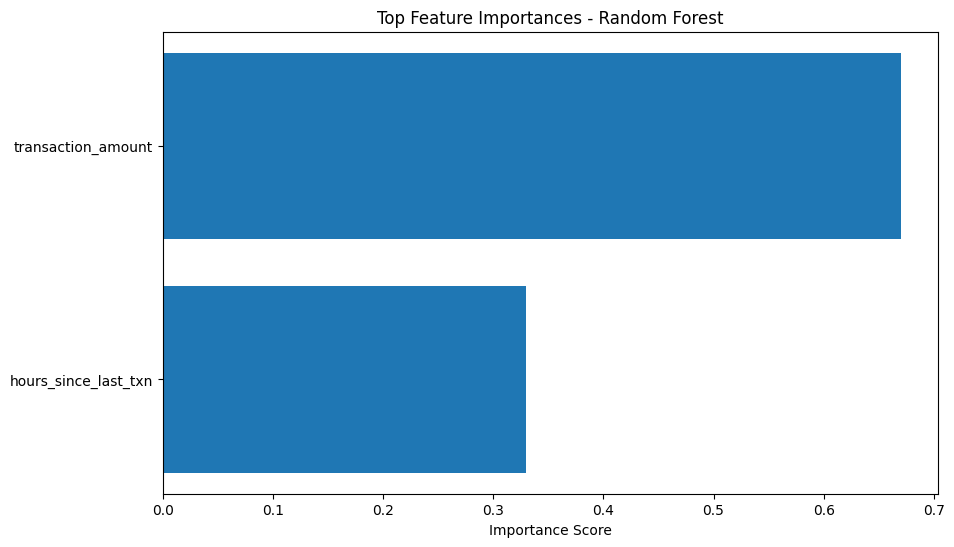

In [70]:
#plot feature importance
import matplotlib.pyplot as plt

top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance['feature'].head(top_n)[::-1],
    feature_importance['importance'].head(top_n)[::-1]
)
plt.xlabel("Importance Score")
plt.title("Top Feature Importances - Random Forest")
plt.show()


**Model Commparison**

In [71]:
model_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "ROC_AUC": [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, y_prob_rf)
    ],
    "Fraud_Recall": [
        classification_report(y_test, y_pred, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall']
    ],
    "Fraud_Precision": [
        classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision']
    ]
})

model_comparison


,Model,ROC_AUC,Fraud_Recall,Fraud_Precision
0,Logistic Regression,1.0,1.0,0.986034
1,Random Forest,1.0,1.0,1.000000


**Get Fraud Probability From Model**

In [72]:
# Predict fraud probability using Random Forest
fraud_probability = rf.predict_proba(X_test)[:, 1]

# Convert to DataFrame
risk_df = X_test.copy()
risk_df['fraud_probability'] = fraud_probability


In [73]:
#Convert Probability to Risk Score (0-100)
# Risk score on scale of 0–100
risk_df['risk_score'] = (risk_df['fraud_probability'] * 100).round(2)


In [74]:
#Create Risk Buckets
def risk_bucket(score):
    if score < 30:
        return 'Low Risk'
    elif score < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

risk_df['risk_category'] = risk_df['risk_score'].apply(risk_bucket)


In [75]:
risk_df['actual_fraud'] = y_test.values
#for dashboard comparison

In [76]:
if 'transaction_id' in df.columns:
    risk_df['transaction_id'] = df.loc[X_test.index, 'transaction_id'].values


In [77]:
risk_df.head()


,transaction_amount,hours_since_last_txn,fraud_probability,risk_score,risk_category,actual_fraud
44570,2399.10,10.92,0.0,0.0,Low Risk,0
43336,1800.50,3.86,0.0,0.0,Low Risk,0
5125,1850.69,3.64,0.0,0.0,Low Risk,0
36829,2166.17,3.41,0.0,0.0,Low Risk,0
39515,5097.41,1.93,0.0,0.0,Low Risk,0


In [78]:
#Sanity check
print(risk_df['risk_category'].value_counts())


risk_category
Low Risk     9647
High Risk     353
Name: count, dtype: int64


In [79]:
risk_df.to_csv("fraud_risk_scoring_output.csv", index=False)
